In [1]:
import heeps
from heeps.wavefront.get_array import get_wf
from heeps.util.coord import mas2rms
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper
%matplotlib inline

## Input parameters

In [2]:
npupil_L = 285              # L band
npupil_N = 119              # N2 band
nimg = 720
dir_current = '$HOME/heeps_metis'
scao = 'input_files/wavefront/cube_Cbasic_20210504_600s_100ms_0piston_meters_scao_only_%s_WV.fits'%nimg
mask = 'input_files/wavefront/mask_Cbasic_20210504_%s.fits'%nimg
dir_current = os.path.normpath(os.path.expandvars(dir_current))
cube = fits.getdata(os.path.join(dir_current, scao))
pup = fits.getdata(os.path.join(dir_current, mask))
#pup[pup < .5] = np.nan
conf = dict(
    npupil = nimg,
    pupil_img_size = 39.9988,
    diam_ext = 39.146,#39.9988,
    diam_int = 9.418,   
    spi_width = 0,
)
obscuration_ratio = conf['diam_int']/conf['diam_ext']
def get_piston(frame):
    return np.mean(frame[frame!=0])
def get_rms(frame):
    return np.std(frame[frame!=0])
def get_zpol(phi, nzer=3):
    #phi[pup!=pup] = np.nan
    zpol = proper.prop_fit_zernikes(phi, pup, nimg/2, nzer, eps=obscuration_ratio, fit=True)
    return zpol
def remove_zernike(wf, phi, zpol):
    proper.prop_zernikes(wf, np.arange(len(zpol))+1, mas2rms(zpol, nimg))
    phiz = get_wf(wf, 'phi', nimg)
    phih = phi - phiz
    phih[pup!=pup] = 0
    phih[pup==0] = 0
    return phih, phiz

In [3]:
wf = heeps.pupil.pupil(**conf)
frames = cube[:2]
zpols = multiCPU(get_zpol, posvars=[frames], kwargs=dict(nzer=21), case='get zpol')
phih, phiz = multiCPU(remove_zernike, posargs=[deepcopy(wf)], posvars=[frames, zpols], \
    case='remove zernike', nout=2)

   2021-05-11 10:12:37, get zpol using 12 cores
   2021-05-11 10:12:37, completed in 0.59 seconds
   2021-05-11 10:12:37, remove zernike using 12 cores
   2021-05-11 10:12:39, completed in 1.29 seconds


### one frame example

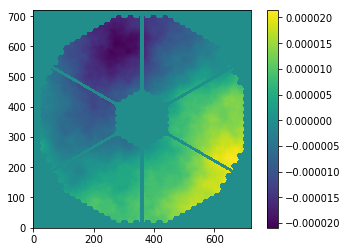

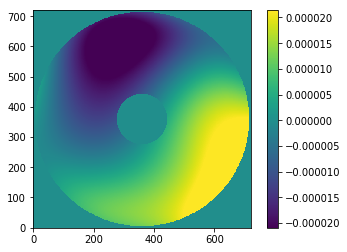

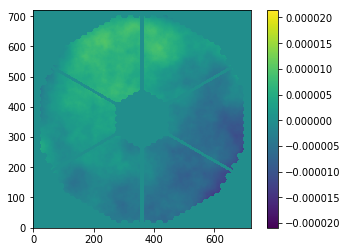

In [4]:
frame=0
plt.figure(), plt.imshow(cube[frame], origin=True), plt.colorbar();
vmin, vmax = plt.gci().get_clim()
plt.figure(), plt.imshow(phiz[frame], origin=True, vmin=vmin, vmax=vmax), plt.colorbar();
plt.figure(), plt.imshow(phih[frame], origin=True, vmin=vmin, vmax=vmax), plt.colorbar();

### full cube

In [5]:
#LSFs_rms = multiCPU(get_rms, posvars=[phiz], case='get rms')
#HSFs_rms = multiCPU(get_rms, posvars=[phih], case='get rms')